# Weighted Portfolio (prettier graphs)

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbols = ['SPY', 'TLT', 'GLD']
weights = {'SPY': 0.50, 'TLT': 0.40, 'GLD': 0.10}
directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG, 'GLD': pf.Direction.LONG}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)

In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital)

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = getattr(row, symbol + '_close')
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,price,shares,entry_exit,direction,symbol
0,2004-12-01,86.95,57,entry,LONG,SPY
1,2004-12-01,51.47,77,entry,LONG,TLT
2,2004-12-01,45.38,22,entry,LONG,GLD
3,2005-01-03,43.02,1,entry,LONG,GLD
4,2005-01-03,53.03,1,exit,LONG,TLT


In [11]:
tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
329,2020-04-01,245.07,2020-07-20,323.00,77.93,233.79,3,28705.93,LONG,SPY
330,2020-05-01,281.55,2020-07-20,323.00,41.45,207.24,5,28913.17,LONG,SPY
331,2020-05-01,167.54,2020-07-20,167.21,-0.32,-1.94,6,28911.23,LONG,TLT
332,2020-06-01,162.09,2020-07-20,167.21,5.13,25.63,5,28936.86,LONG,TLT
333,2020-07-01,163.42,2020-07-20,167.21,3.79,3.79,1,28940.65,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-14,38676.89,38676.89,38676.89,174,422.46,1.00,-
2020-07-15,38784.22,38784.22,38784.22,174,422.46,1.00,-
2020-07-16,38757.89,38757.89,38757.89,174,422.46,1.00,-
2020-07-17,38812.06,38812.06,38812.06,174,422.46,1.00,-
2020-07-20,38940.65,38940.65,38940.65,0,38940.65,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2020-07-20
beginning_balance                                           10000
ending_balance                                           38940.65
total_net_profit                                         28940.65
gross_profit                                             29357.21
gross_loss                                                -416.55
profit_factor                                               70.48
return_on_initial_capital                                  289.41
annual_return_rate                                           9.06
trading_period                           15 years 8 months 2 days
pct_time_in_market                                          99.80
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-07-20 00:00:00 SELL 115 SPY @ 323.00


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

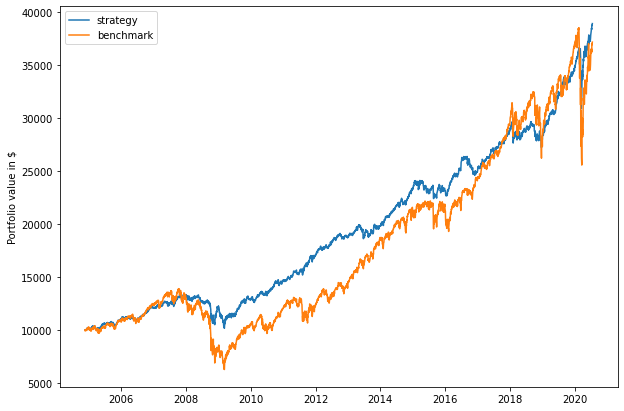

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

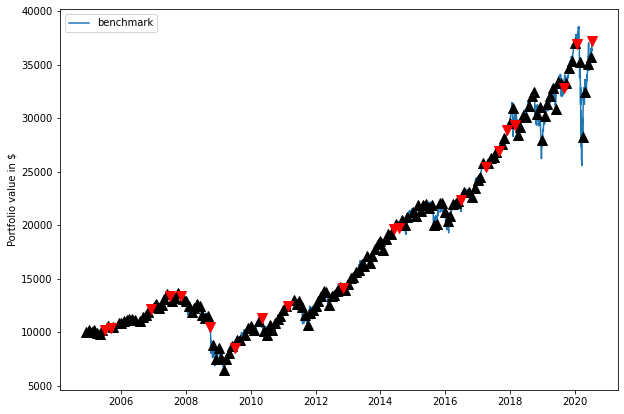

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$38,940.65","$37,186.74"
total_net_profit,"$28,940.65","$27,186.74"
gross_profit,"$29,357.21","$27,186.74"
gross_loss,-$416.55,$0.00


,strategy,benchmark
annual_return_rate,9.06,8.74
max_closed_out_drawdown,-24.05,-55.02
drawdown_annualized_return,-2.65,-6.29
drawdown_recovery,-1.26,-1.42
best_month,16.84,23.46
worst_month,-15.59,-30.95
sharpe_ratio,1.03,0.53
sortino_ratio,1.34,0.63
monthly_std,2.36,4.57


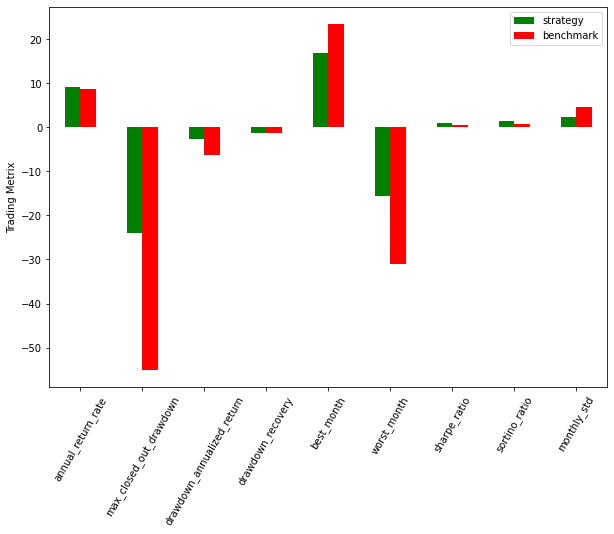

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df

In [21]:
returns = dbal['close']
returns.tail()

date
2020-07-14   38676.89
2020-07-15   38784.22
2020-07-16   38757.89
2020-07-17   38812.06
2020-07-20   38940.65
Name: close, dtype: float64

In [22]:
benchmark_returns = benchmark.dbal['close']
benchmark_returns.tail()

date
2020-07-14   36717.54
2020-07-15   37054.49
2020-07-16   36932.59
2020-07-17   37039.54
2020-07-20   37186.74
Name: close, dtype: float64

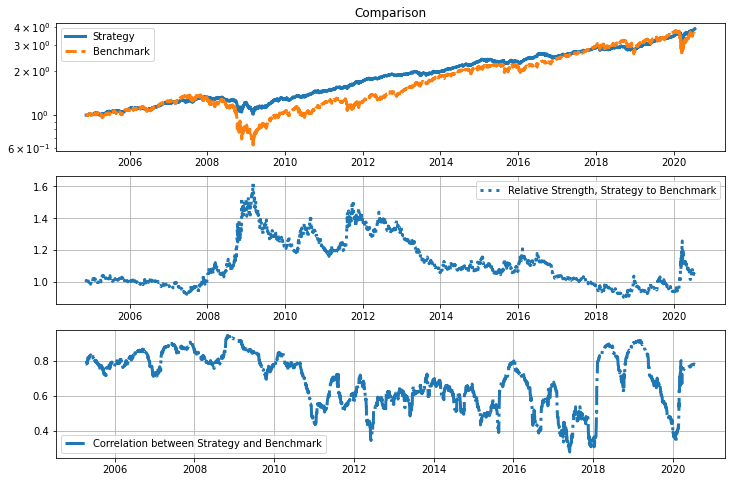

In [23]:
pf.prettier_graphs(returns, benchmark_returns,
                   label1='Strategy', label2='Benchmark',
                   points_to_plot=5000)